In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random
import pickle
import scipy

import mlrfit as mf
import mfmodel as mfm

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate samples using 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [3]:
mtype = "mlr_hier_cov_gics2"
rank = 30
n = 5000
signal_to_noise = 4


nsamples = 300
L = 6

ranks = np.array([14, 6, 4, 3, 2, 1])

In [4]:
with open("../../mlr_fitting_private/data_finance/crsp_gics_5k_hpart.pkl", "rb") as f:
       hpart = pickle.load(f)
part_sizes = mfm.print_hpart_numgroups(hpart)

level=0, num_groups=1, mean_size=5000.0
level=1, num_groups=11, mean_size=454.5
level=2, num_groups=24, mean_size=208.3
level=3, num_groups=69, mean_size=72.5
level=4, num_groups=157, mean_size=31.8
level=5, num_groups=5000, mean_size=1.0


In [5]:
true_mlr, true_sparse_F, true_D_noise = mfm.generate_mlr_model(n, hpart, ranks, signal_to_noise)

signal_var=28.967422298555448, noise_var=7.201470189973824
SNR=4.02243174440756, signal_to_noise=4


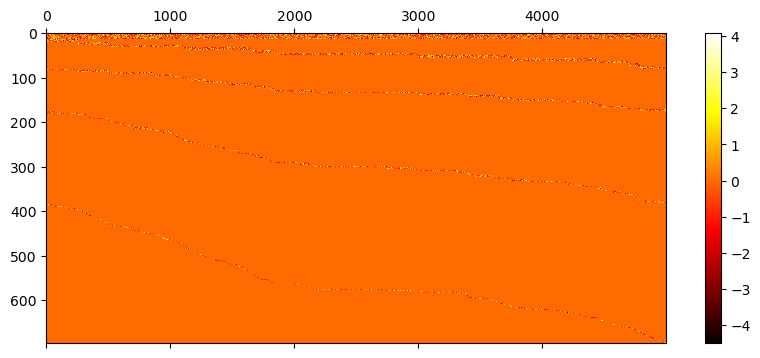

(5000, 697)


In [6]:
plt.figure(figsize=(10, 4)) 
plt.matshow(true_sparse_F.T, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()
print(true_sparse_F.shape)

In [7]:
C = mfm.generate_data(true_sparse_F, true_D_noise, nsamples, true_mlr)

Z = (C - C.mean(axis=1, keepdims=True))[hpart["rows"]["pi"], :]
unpermuted_A = (Z @ Z.T / (Z.shape[1]-1))[true_mlr.pi_inv_rows, :][:, true_mlr.pi_inv_cols]

# permute to put clusters on diagonal
Y = Z.T
N = Y.shape[0]

In [8]:
type(true_sparse_F)

numpy.ndarray

In [9]:
perm_true_covariance = true_sparse_F @ true_sparse_F.T + np.diag(true_D_noise)
np.linalg.norm(unpermuted_A[hpart["rows"]["pi"], :][:, hpart["rows"]["pi"]] - perm_true_covariance, 'fro') / np.linalg.norm(perm_true_covariance, 'fro') 

0.5254704220716414

In [10]:
C.shape, Z.shape, unpermuted_A.shape

((5000, 300), (5000, 300), (5000, 5000))

In [11]:
filename = "%s_r%d_%d"%(mtype, rank, n)

In [12]:
row_selectors, si_groups, F_hpart = mfm.row_col_selections(hpart)

num_levels=6, num_sparsities=157
(157, 5) [  0  10  23  68 156]


# True model loglikelihoods

In [13]:
true_Sigma = mfm.perm_hat_Sigma_sp(true_sparse_F, true_D_noise)
tr_lu, tr_piv = scipy.linalg.lu_factor(true_Sigma)
true_train_obj = mfm.loglikelihood_value(true_Sigma, tr_lu, tr_piv, Y)
exp_true_ll = mfm.exp_true_loglikelihood_value(true_Sigma)
print(f"TR: train ll={true_train_obj}, exp ll={exp_true_ll}")

TR: train ll=-12195.82265977308, exp ll=-12204.739769552163


In [14]:
assert np.allclose(exp_true_ll, mfm.exp_loglikelihood_value(true_Sigma, true_Sigma, tr_lu, tr_piv))

In [15]:
np.linalg.slogdet(true_Sigma), true_sparse_F.shape

((1.0, 10220.0942070576), (5000, 697))

# Frobenius norm-based loss

In [16]:
obj_frobs = {}

print(ranks.sum())
hat_A = mf.MLRMatrix()
hat_A.hpart = hpart
losses = hat_A.factor_fit(unpermuted_A, ranks, hat_A.hpart, eps_ff=1e-3, PSD=True, freq=1, \
                                printing=True, max_iters_ff=50, symm=True)

F_frob, D_frob = hat_A.B[:, :-1], np.square(hat_A.B[:, -1])
Sigma_frob = mfm.perm_hat_Sigma(F_frob, D_frob, F_hpart, ranks)
frob_lu, frob_piv = scipy.linalg.lu_factor(Sigma_frob)
obj_frob = mfm.loglikelihood_value(Sigma_frob, frob_lu, frob_piv, Y)

exp_obj_frob = mfm.exp_loglikelihood_value(true_Sigma, Sigma_frob, frob_lu, frob_piv)
print(f"FR: train ll={obj_frob}, exp ll={exp_obj_frob}, {losses[-1]=}")
obj_frobs[str(ranks)] = {"train":obj_frob, "exp":exp_obj_frob}

30


/Users/parshakova.tanya/Documents/projects/MLR_Matrices/mlr_fitting/mlrfit/utils.py:408: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  hat_A_except_level[r1:r2, c1:c2] += np.dot(B_level[r1:r2], C_level[c1:c2].T)


itr=0, 0.2721895700072558, [14  6  4  3  2  1]
itr=1, 0.2721895700072558, [14  6  4  3  2  1]
itr=1, 0.2678288538864321, [14  6  4  3  2  1], time_v_epoch=17.232670068740845, time_loss=1.1586840152740479
itr=2, 0.26722932627542767, [14  6  4  3  2  1], time_v_epoch=17.66803002357483, time_loss=1.0927369594573975
itr=3, 0.2667903905502956, [14  6  4  3  2  1], time_v_epoch=16.861168146133423, time_loss=1.1468582153320312
itr=4, 0.2664566750381608, [14  6  4  3  2  1], time_v_epoch=17.529829740524292, time_loss=1.302610158920288
itr=5, 0.2662101984446479, [14  6  4  3  2  1], time_v_epoch=20.345659971237183, time_loss=1.3381540775299072
FR: train ll=-11990.498039121776, exp ll=-12585.806084417562, losses[-1]=0.26611262248690215


In [17]:
mf.rel_diff(hat_A.matrix(), den=unpermuted_A), np.linalg.slogdet(hat_A.matrix())

(0.26611262248690204, (1.0, 9793.790275782112))

# MLE-based loss

In [18]:
loglikelihoods, F0, D0 = mfm.em_algorithm(n, Y, part_sizes, F_hpart, row_selectors, si_groups, 
                                         ranks, max_iter=300, eps=1e-8, printing=True, freq=1,
                                         F0=np.random.randn(n, rank-1), 
                                         D0=np.square(np.random.rand(n))+1)

t=0, obj=-67989.3222554859
t=1, obj=-14618.243242359285
t=2, obj=-13553.238274709154
t=3, obj=-13080.66649443227
t=4, obj=-12819.028394590014
t=5, obj=-12674.132529591245
t=6, obj=-12570.359908187058
t=7, obj=-12491.69718841067
t=8, obj=-12444.778417956246
t=9, obj=-12413.49267552104
t=10, obj=-12389.871523098094
t=11, obj=-12371.109681394317
t=12, obj=-12355.568905422977
t=13, obj=-12342.262582632391
t=14, obj=-12330.626813870203
t=15, obj=-12320.383052891579
t=16, obj=-12311.428219662646
t=17, obj=-12303.706946531009
t=18, obj=-12297.105065582686
t=19, obj=-12291.418198570613
t=20, obj=-12286.432092712605
t=21, obj=-12281.978646939053
t=22, obj=-12277.93620754475
t=23, obj=-12274.218194386885
t=24, obj=-12270.763355079656
t=25, obj=-12267.526453491359
t=26, obj=-12264.469385277784
t=27, obj=-12261.555428314283
t=28, obj=-12258.747781896163
t=29, obj=-12256.010190121433
t=30, obj=-12253.307266745069
t=31, obj=-12250.603982888113
t=32, obj=-12247.864688267615
t=33, obj=-12245.051608166

In [19]:
ll_hier = np.copy(np.array(loglikelihoods))

In [20]:
Sigma0 = mfm.perm_hat_Sigma(F0, D0, F_hpart, ranks)
mf.rel_diff(Sigma0, den=unpermuted_A[hat_A.pi_rows, :][:, hat_A.pi_cols]), np.linalg.slogdet(Sigma0)

(54.349144291339314, (1.0, 9802.810398660462))

In [21]:
mle_lu, mle_piv = scipy.linalg.lu_factor(Sigma0)
exp_mle_obj = mfm.exp_loglikelihood_value(true_Sigma, Sigma0, mle_lu, mle_piv)

print(f"ML: train ll={loglikelihoods[-1]}, exp ll={exp_mle_obj}")
ll_hier = {"train":ll_hier, "exp":exp_mle_obj}

ML: train ll=-11975.12154546041, exp ll=-12564.018442198745


In [22]:
obj_frobs[str(ranks)]

{'train': -11990.498039121776, 'exp': -12585.806084417562}

In [23]:
with open(f"outputs/em_{mtype}.pickle", 'wb') as handle:
    lls = {"hier":ll_hier, "frob":obj_frobs}
    pickle.dump(lls, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
# true model maximizes the expected likelihood of data sample
assert exp_true_ll > obj_frobs[str(ranks)]["exp"] and exp_true_ll > ll_hier["exp"]
print(exp_true_ll, ll_hier["exp"], obj_frobs[str(ranks)]["exp"], ll_hier["exp"] - obj_frobs[str(ranks)]["exp"])

-12204.739769552163 -12564.018442198745 -12585.806084417562 21.787642218816472


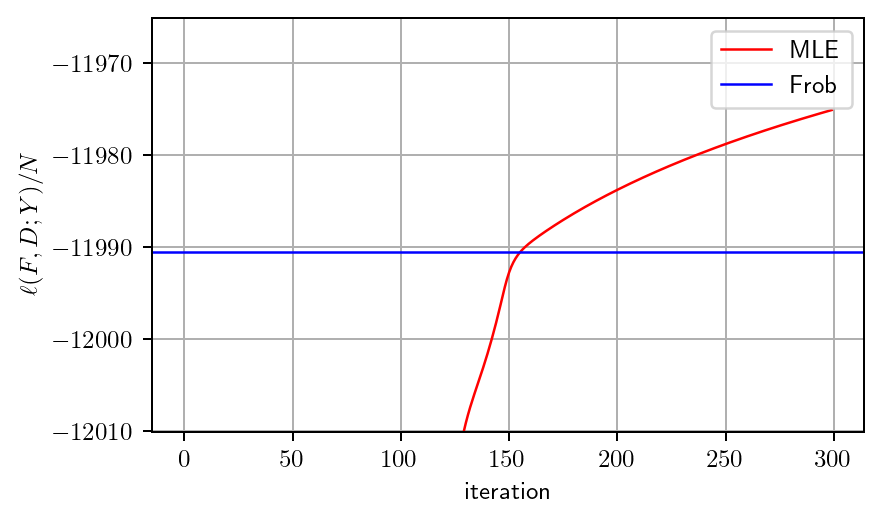

In [25]:
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath}"
})
fig, axs = plt.subplots(1, 1, figsize=(5, 3), dpi=180, sharey=True)

ll = ll_hier["train"][1:]
# print(f"{ranks=}, difference={(ll[-1]-obj_frobs[str(ranks)]["train"]):.2f}, %increase={(ll[-1]-obj_frobs[str(ranks)]["train"])/obj_frobs[str(ranks)]["train"]*100:.2f}")
axs.plot(ll, color='r', lw=1, label=r"$\text{MLE}$")
axs.set_xlabel('iteration')
axs.axhline(obj_frobs[str(ranks)]["train"], 0, ll.size-1, color='b', lw=1, label=r"$\text{Frob}$")
axs.set_ylabel(r'$\ell(F, D; Y)/N$')
# axs.set_yscale('symlog')
axs.set_ylim([ll.max() - 35, ll.max() + 10])
axs.grid(True)
axs.legend()
    # axs[i].set_title(f"ranks$={list(ranks)}$")
# plt.show()
plt.tight_layout()
# yticks = [10**3*(ll.max()//1000) - 1000, 10**3*(ll.max()//1000) + 1000]
# axs.set_yticks(yticks)
# axs.set_yticklabels([str(ytick) for ytick in yticks])
# plt.gca().set_ylim(ll.max() - 100, ll.max() + 100)
# fig.suptitle("Observed data log-likelihood", fontsize=16, y=1.05)
plt.savefig(f"plots/em_{mtype}.pdf", bbox_inches='tight')

In [26]:
assert Z.shape[1] == nsamples

In [29]:
np.linalg.slogdet(hat_A.matrix())

(1.0, 9793.790275782112)

In [28]:
loglikelihoods = loglikelihoods[:51] + loglikelihoods[52:]